In [1]:
import numpy as np
import pandas as pd
import magec_utils as mg
import mimic_utils as mimic
import matplotlib
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
import seaborn as sns
from keras.models import Sequential, Model
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import ReLU
from keras.layers import Input
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import random as python_random

pd.set_option('display.max_columns', None)

%matplotlib inline

Using TensorFlow backend.


In [2]:
def create_mlp():
    mlp = Sequential()
    mlp.add(Dense(60, input_dim=len(xst_train.columns), activation='relu'))
    mlp.add(Dropout(0.5))
    mlp.add(Dense(30, input_dim=60, activation='relu'))
    mlp.add(Dropout(0.5))
    mlp.add(Dense(1, activation='sigmoid'))
    mlp.compile(loss='binary_crossentropy',
                optimizer='adam', metrics=['accuracy'])
    return mlp

def impute(df):
    df[labs] = df[labs].fillna(df[labs].mean())
    for vital in vitals:
        df['first_'+vital] = df['first_'+vital].fillna(df['first_'+vital].mean())
        df['last_'+vital] = df['last_'+vital].fillna(df['last_'+vital].mean())    
    df[comobs] = df[comobs].fillna(0)
    return df

def featurize(df, outcome):
    out = dict()
    for lab in labs:
        out[lab] = last_val(df[lab])
    for vital in vitals:
        out['first_'+vital] = first_val(df[vital])
        out['last_'+vital] = last_val(df[vital])
    for comob in comobs:
        out[comob] = last_val(df[comob])
    for other in others:
        out[other] = last_val(df[other])
    out['label'] = int(df[outcome].iloc[-1])
    return pd.Series(out)

def first_val(x):
    vals = list(x[~np.isnan(x)])
    if len(vals):
        return vals[0]
    else:
        return None

def last_val(x):
    vals = list(x[~np.isnan(x)])
    if len(vals):
        return vals[-1]
    else:
        return None

def train_valid_ml(df_ml, test_size=0.2, seed=7):
    np.random.seed(seed)

    x_cols = list(set(df_ml.columns) - {'label'})
    y_cols = ['case', 'label']

    cases = df_ml['case'].unique()

    np.random.shuffle(cases)  # inplace shuffle

    valid_cases = cases[:int(len(cases) * test_size)]
    train_cases = cases[int(len(cases) * test_size):]

    train_cases = np.isin(df_ml['case'], train_cases)
    valid_cases = np.isin(df_ml['case'], valid_cases)

    xy_train = df_ml.loc[train_cases, :]
    x_train = xy_train[x_cols].copy()
    Y_train = xy_train[y_cols].copy()

    Y_train['label'] = Y_train['label'].astype(int)
    Y_train['timepoint'] = 0
    Y_train = Y_train.set_index(['case', 'timepoint'])
    
    xy_valid = df_ml.loc[valid_cases, :]
    x_valid = xy_valid[x_cols].copy()
    Y_valid = xy_valid[y_cols].copy()
    
    Y_valid['label'] = Y_valid['label'].astype(int)
    Y_valid['timepoint'] = 0
    Y_valid = Y_valid.set_index(['case', 'timepoint'])
    
    x_train = impute(x_train)
    x_train['timepoint'] = 0
    x_valid = impute(x_valid)
    x_valid['timepoint'] = 0
    
    x_train = x_train.set_index(['case', 'timepoint'])
    
    x_valid = x_valid.set_index(['case', 'timepoint'])
    
    feats = x_train.columns
    
    bool_cols = [col for col in feats if df_ml[col].dropna().value_counts().index.isin([0,1]).all()]
    non_bool_cols = [col for col in feats if col not in bool_cols]
     
    stsc = StandardScaler()
    xst_train = x_train.copy()
    xst_train[non_bool_cols] = stsc.fit_transform(x_train[non_bool_cols])
    xst_train = pd.DataFrame(xst_train, index=x_train.index, columns=x_train.columns)

    xst_valid = x_valid.copy()
    xst_valid[non_bool_cols] = stsc.transform(x_valid[non_bool_cols])
    xst_valid = pd.DataFrame(xst_valid, index=x_valid.index, columns=x_valid.columns)

    return x_train, x_valid, stsc, xst_train, xst_valid, Y_train, Y_valid

In [3]:
# MIMIC-III
vitals = ['heartrate_mean', 'sysbp_mean', 'diasbp_mean', 'meanbp_mean',
          'resprate_mean', 'tempc_mean', 'spo2_mean', 'glucose_mean']

labs = ['aniongap', 'albumin', 'bicarbonate', 'bilirubin', 'creatinine', 
        'chloride', 'glucose', 'hemoglobin', 'lactate', 
        'magnesium', 'phosphate', 'platelet', 'potassium', 'ptt', 'inr', 
        'pt', 'sodium', 'bun', 'wbc']  # -hematocrit

comobs = ['congestive_heart_failure', 'chronic_pulmonary', 'pulmonary_circulation']

others = ['age', 'gender']

features = vitals+labs

df_cohort = mimic.get_mimic_data()

df_ml = df_cohort.rename(columns={'subject_id': 'case'})
df_ml = df_ml.set_index(['case', 'timepoint'])
df_ml = df_ml.sort_index(level=[0, 1], ascending=[1, 0])

df_ml = df_ml.reset_index(1).groupby(level=0, group_keys=False).apply(lambda x: featurize(x, 'ventilated'))

x_train, x_valid, stsc, xst_train, xst_valid, Y_train, Y_valid = train_valid_ml(df_ml.reset_index())

class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(Y_train['label']),
                                                  Y_train['label'])
print(class_weights)

[0.61911131 2.59887711]


In [4]:
np.random.seed(123)
python_random.seed(123)
tf.random.set_seed(1234)

mlp1 = KerasClassifier(build_fn=create_mlp, epochs=100, batch_size=64, verbose=0)
mlp1.fit(xst_train, Y_train['label'], 
         epochs=100, 
         batch_size=64, 
         verbose=0, 
         class_weight={0:class_weights[0], 1:class_weights[1]}, )
print('Built MLP1 classifier!')


np.random.seed(321)
python_random.seed(321)
tf.random.set_seed(4321)

mlp2 = KerasClassifier(build_fn=create_mlp, epochs=100, batch_size=64, verbose=0)
mlp2.fit(xst_train, Y_train['label'], 
         epochs=100, 
         batch_size=64, 
         verbose=0, 
         class_weight={0:class_weights[0], 1:class_weights[1]}, )
print('Built MLP2 classifier!')


np.random.seed(231)
python_random.seed(231)
tf.random.set_seed(2314)

mlp3 = KerasClassifier(build_fn=create_mlp, epochs=100, batch_size=64, verbose=0)
mlp3.fit(xst_train, Y_train['label'], 
         epochs=100, 
         batch_size=64, 
         verbose=0, 
         class_weight={0:class_weights[0], 1:class_weights[1]}, )
print('Built MLP3 classifier!')

sv = svm.SVC(probability=True, class_weight="balanced")
sv.fit(xst_train, Y_train['label'])
print('Built SVM classifier!')

lr = LogisticRegression(C=1., class_weight='balanced', solver='lbfgs')
lr.fit(xst_train, Y_train['label'])
print('Built LR classifier!')

Built MLP1 classifier!
Built MLP2 classifier!
Built MLP3 classifier!
Built SVM classifier!
Built LR classifier!


## MAgEC Models

In [5]:
mg.evaluate(mlp1, xst_valid, Y_valid['label'], verbose=True);
mg.evaluate(mlp2, xst_valid, Y_valid['label'], verbose=True);
mg.evaluate(mlp3, xst_valid, Y_valid['label'], verbose=True);
mg.evaluate(sv, xst_valid, Y_valid['label'], verbose=True);
mg.evaluate(lr, xst_valid, Y_valid['label'], verbose=True);

Accuracy: 0.802208
Precision: 0.504303
Recall: 0.702638
F1 score: 0.587174
ROC AUC: 0.838599
[[1378  288]
 [ 124  293]]
Accuracy: 0.794527
Precision: 0.490468
Recall: 0.678657
F1 score: 0.569416
ROC AUC: 0.835900
[[1372  294]
 [ 134  283]]
Accuracy: 0.819971
Precision: 0.541667
Recall: 0.654676
F1 score: 0.592834
ROC AUC: 0.832817
[[1435  231]
 [ 144  273]]
Accuracy: 0.783485
Precision: 0.472131
Recall: 0.690647
F1 score: 0.560857
ROC AUC: 0.813949
[[1344  322]
 [ 129  288]]
Accuracy: 0.672588
Precision: 0.339782
Recall: 0.673861
F1 score: 0.451768
ROC AUC: 0.721519
[[1120  546]
 [ 136  281]]


In [6]:
def most_abnormal(x, features):
    res = None
    feat = None
    for f in features:
        if res is None or abs(x[f]) > res:
            res = abs(x[f])
            feat = f
    return feat

def get_magecs(m1, m2, m3, xst_valid, Ydata, baseline=None, models=('mlp1', 'mlp2', 'mlp3')):
    
    magecs1 = mg.case_magecs(m1, xst_valid, model_name=models[0], baseline=baseline)
    magecs1 = mg.normalize_magecs(magecs1, features=None, model_name=models[0])
   
    magecs2 = mg.case_magecs(m2, xst_valid, model_name=models[1], baseline=baseline)
    magecs2 = mg.normalize_magecs(magecs2, features=None, model_name=models[1])
    
    magecs3 = mg.case_magecs(m3, xst_valid, model_name=models[2], baseline=baseline)
    magecs3 = mg.normalize_magecs(magecs3, features=None, model_name=models[2])
    
    feats = list(xst_valid.columns)
    
    joined = mg.magec_models(magecs1, magecs2, magecs3, 
                             Xdata=xst_valid, Ydata=Ydata['label'], features=feats)
    
    prob_cols = [c for c in joined.columns if c.startswith('perturb') and '_'.join(c.split('_')[1:-2]) in feats]
    
    joined['orig_prob_ensemble'] = joined[['orig_prob_'+models[0], 
                                           'orig_prob_'+models[1], 
                                           'orig_prob_'+models[2]]].apply(np.mean, 1)
    
    joined[['best_feat', 'new_risk', 'rank_feat', 'rank_val', 'top_rank_prob']] = joined.apply(
        lambda x: mimic.best_feature(x, prob_cols), axis=1)
    joined['most_abnormal'] = joined.apply(lambda x: most_abnormal(x, feats), axis=1)
    
    ranks = mg.magec_rank(joined, rank=len(feats), features=feats, models=models)
    
    rbos = mg.magec_rbos(ranks, models=models)
    
    if models == ('mlp1', 'mlp2', 'mlp3'):
        rbo_cols = ['mlp2_mlp1', 'mlp3_mlp1', 'mlp3_mlp2']
    else:
        rbo_cols = ['mlp_lr', 'svm_lr', 'svm_mlp']
    
    rbos['rbo'] = rbos[rbo_cols].apply(np.mean, 1)
    
    consensus = mg.magec_consensus(ranks, models=models)
    consensus = consensus.merge(rbos[['rbo', 'case']], left_on='case', right_on='case')
    consensus = consensus.merge(Ydata.reset_index()[['case','label']], left_on='case', right_on='case')
        
    return joined, ranks, consensus, rbos

## MAgEC Experiements

In [7]:
_, _, consensus_homo, _ = get_magecs(mlp1, mlp2, mlp3, 
                                     xst_valid, Y_valid, baseline=None)

In [8]:
_, _, consensus_heto, _ = get_magecs(mlp3, sv, lr,  
                                     xst_valid, Y_valid, baseline=None, 
                                     models=('mlp', 'svm', 'lr'))

In [9]:
_, _, consensus_p5, _ = get_magecs(mlp3, sv, lr,  
                                   xst_valid, Y_valid, baseline=0.5, 
                                   models=('mlp', 'svm', 'lr'))

_, _, consensus_p3, _ = get_magecs(mlp3, sv, lr,  
                                   xst_valid, Y_valid, baseline=0.3, 
                                   models=('mlp', 'svm', 'lr'))

_, _, consensus_p1, _ = get_magecs(mlp3, sv, lr,  
                                   xst_valid, Y_valid, baseline=0.1, 
                                   models=('mlp', 'svm', 'lr'))

## RBO Plots

In [10]:
cons1 = consensus_homo[['winner','rbo']].copy()
cons1['panel'] = 'homogeneous'
cons2 = consensus_heto[['winner','rbo']].copy()
cons2['panel'] = 'heterogeneous'
cons = pd.concat([cons1, cons2], axis=0)

In [11]:
assert len(cons) == len(cons1)*2

In [19]:
def plot_rbo(df, save=''):
    fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(12, 16))
    order = list(df.winner.value_counts().index.values)
    sns.barplot(x='rbo', 
                y='winner',
                hue='panel',
                data=df, 
                order=order,
                palette="pastel", 
                edgecolor=".6",
                ci=None,
                ax=ax);
    ax.grid('on')
    ax.set_title('MAgEC Average RBO')
    ax.set_ylabel('Top MAgEC')
    ax.set_xlabel('Average RBO from pairwise model RBOs')
    ax.legend(['homogeneous', 'heterogeneous'], loc='lower right')
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(20)
    if save:
        fig.savefig(save, bbox_inches='tight')

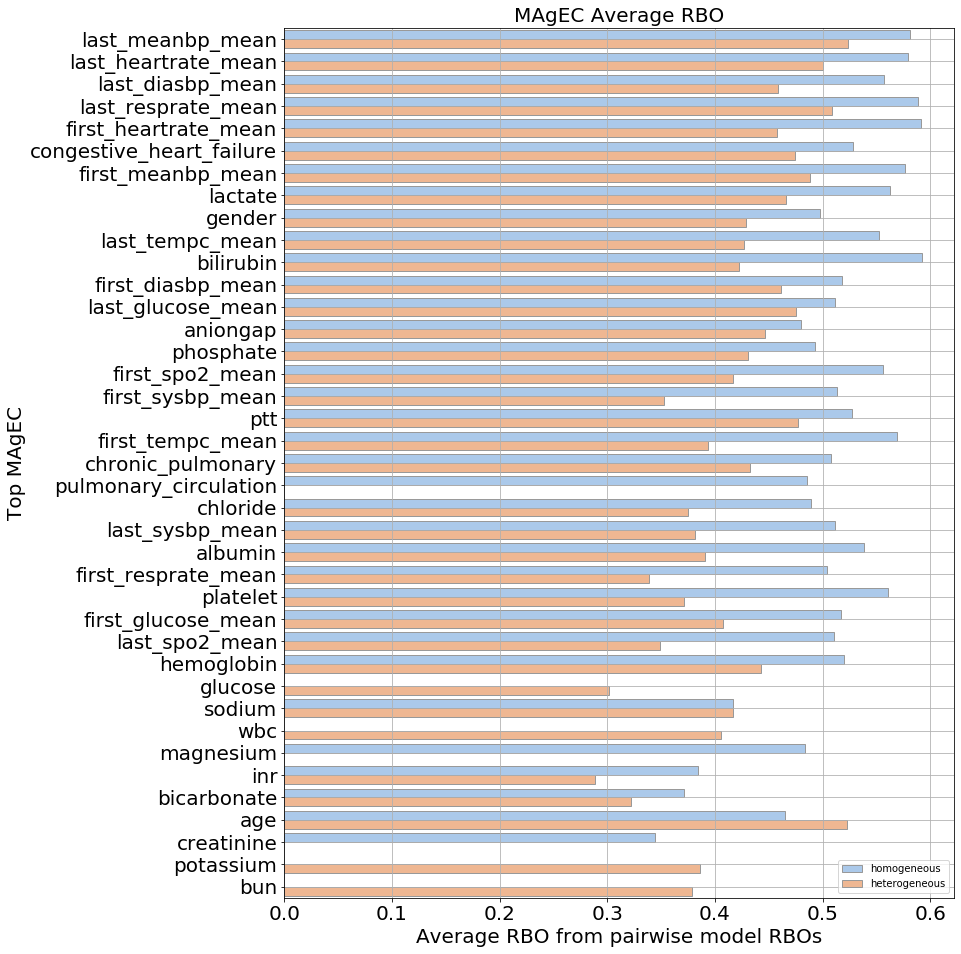

In [21]:
plot_rbo(cons, save='rbo_panels_comp.png')

## Sensitivity Plots

In [12]:
def plot_sensitivity(consens, title='', topK=None, save=''):
   
    fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(28, 12), sharey=True)
        
    df = consens
    order = list(df[(df['label']==1)&(df['perturb']=='full')][['winner']].winner.value_counts().index.values) 
    if topK is not None:
        order =  order[:topK]
        df = df[np.isin(df['winner'], order)]
        
    sns.countplot(y="winner", 
                  hue="perturb", 
                  palette="pastel", 
                  edgecolor=".6",
                  data=df[df['label']==1], 
                  order=order,
                  ax=ax[0]);
    
    sns.countplot(y="winner", 
                  hue="perturb", 
                  palette="pastel", 
                  edgecolor=".6",
                  data=df[df['label']==0], 
                  order=order,
                  ax=ax[1]);
        
    
    ax[0].set_title('Label=1' + title)
    ax[0].set_ylabel('Top Magec')
    ax[0].grid('on')
    
    ax[1].set_ylabel('')
    ax[1].set_title('Label=0' + title)
    ax[1].grid('on')
    
    for item in ([ax[0].title, ax[0].xaxis.label, ax[0].yaxis.label] +
             ax[0].get_xticklabels() + ax[0].get_yticklabels()):
        item.set_fontsize(21)
        
    for item in ([ax[1].title, ax[1].xaxis.label, ax[1].yaxis.label] +
             ax[1].get_xticklabels() + ax[1].get_yticklabels()):
        item.set_fontsize(21)
    
    plt.tight_layout()

    if save:
        fig.savefig(save, bbox_inches='tight')

In [13]:
c1 = consensus_heto[['case','winner','label','score']].copy()
c1['perturb'] = 'full'

c2 = consensus_p5[['case','winner','label','score']].copy()
c2['perturb'] = '0.5'

c3 = consensus_p3[['case','winner','label','score']].copy()
c3['perturb'] = '0.3'

c4 = consensus_p1[['case','winner','label','score']].copy()
c4['perturb'] = '0.1'

consens = pd.concat([c1, c2, c3, c4], axis=0)

In [14]:
len(consens) == 4 * len(consensus_heto)

True

In [15]:
bool_cols = [col for col in list(xst_valid.columns) 
             if df_ml[col].dropna().value_counts().index.isin([0,1]).all()]
non_bool_cols = [col for col in list(xst_valid.columns) 
                 if col not in bool_cols]

In [16]:
consens = consens[np.isin(consens['winner'], non_bool_cols)]

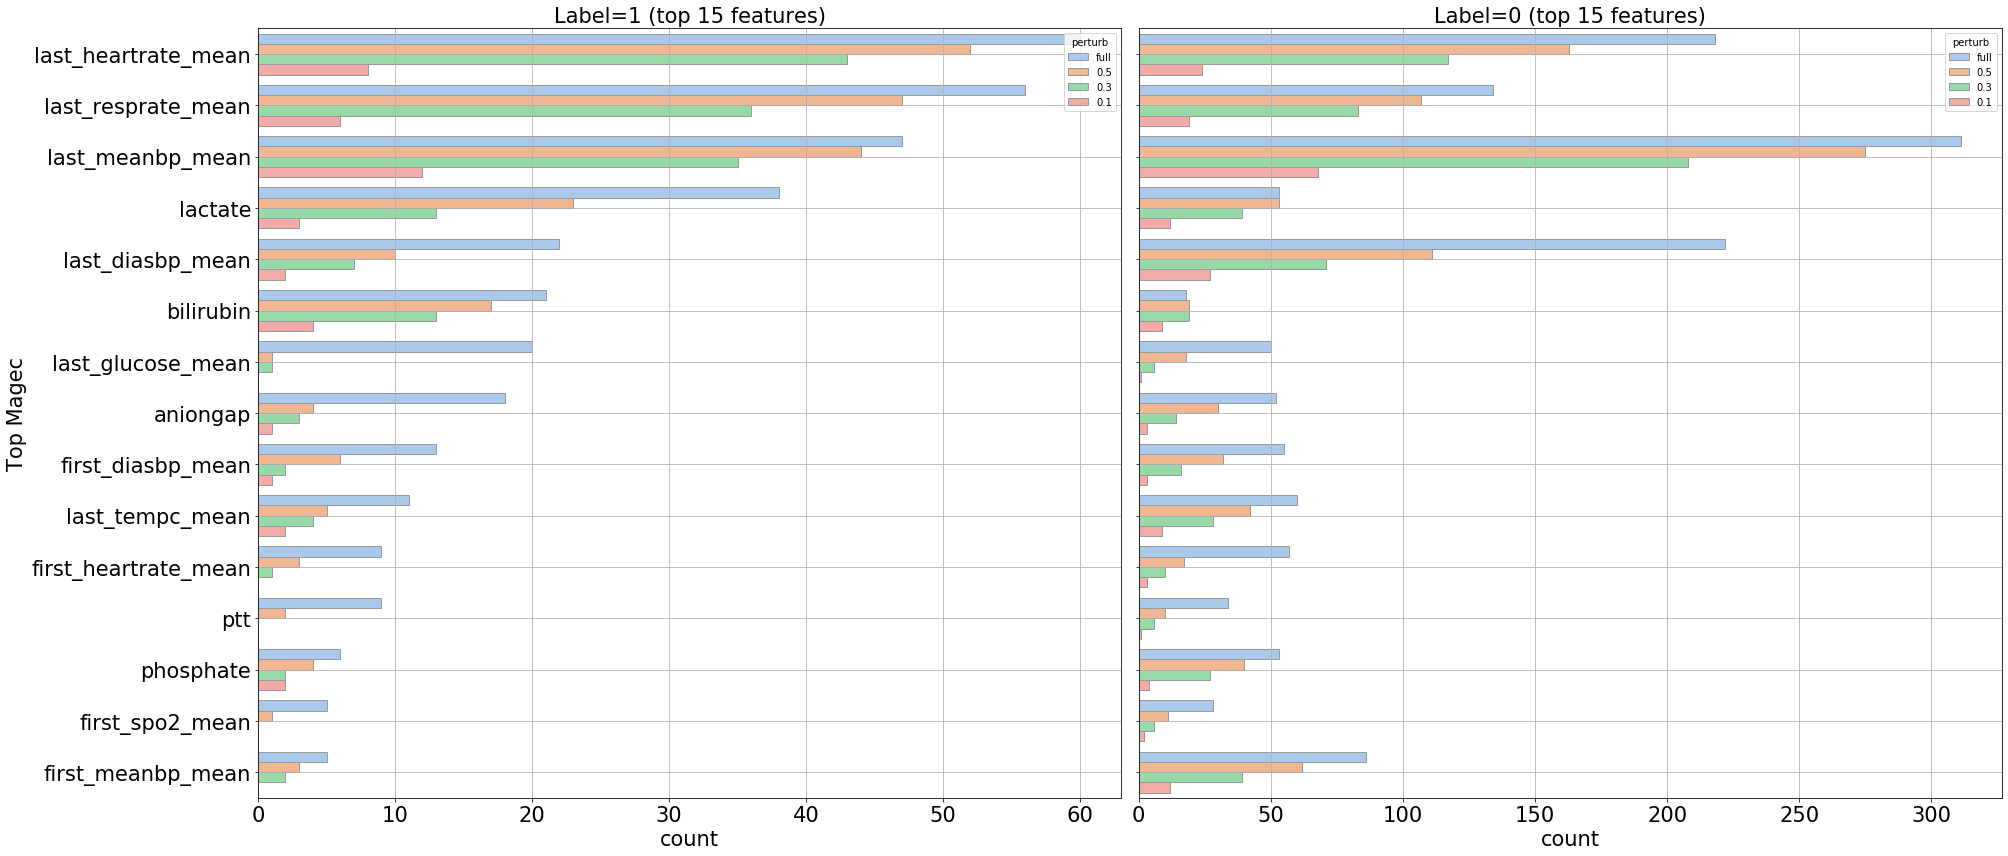

In [30]:
plot_sensitivity(consens, topK=15, title=' (top 15 features)', save='magec_sensitivity_plot.png')

## MAgEC Feature Importance Plots

In [37]:
def plot_feat_importance(consensus, shaps, feats=None, save=''):
    if feats is not None:
        df = consensus[np.isin(consensus['winner'], feats)]
    else:
        df = consensus
    
    sh1 = shaps[shaps['label']==1]
    sh0 = shaps[shaps['label']==0]
    
    df1 = df[df['label']==1]
    df0 = df[df['label']==0]
    
    order1 = list(df1.winner.value_counts().index.values)
    order0 = list(df0.winner.value_counts().index.values)
    
    a4_dims = (20, 20)
    
    fig, ax = plt.subplots(nrows=2, ncols=2, sharey=True, figsize=a4_dims)
    
    sns.countplot(y="winner", 
                  palette="pastel", 
                  edgecolor=".6",
                  data=df1, 
                  order=order1,
                  ax=ax[0][0]);
    
    sns.countplot(y="winner", 
                  palette="pastel", 
                  edgecolor=".6",
                  data=df0, 
                  order=order0,
                  ax=ax[1][0]);

    sns.barplot(x='shap', 
                y='feature' ,
                data=sh1, 
                order=order1,
                palette="pastel", 
                edgecolor=".6",
                ax=ax[0][1]);
    
    sns.barplot(x='shap', 
                y='feature' ,
                data=sh0, 
                order=order0,
                palette="pastel", 
                edgecolor=".6",
                ax=ax[1][1]);
    
    ax[0][0].set_title('Top MAgEC Feature for Label=1')
    ax[1][0].set_title('Top MAgEC Feature for Label=0')
    ax[0][0].set_ylabel('Top Magec')
    ax[1][0].set_ylabel('Top Magec')
    
    ax[0][1].set_title('Feature importance using SHAP for Label=1')
    ax[1][1].set_title('Feature importance using SHAP for Label=0')
    ax[0][1].set_xlabel('mean(|SHAP value|)')
    ax[1][1].set_xlabel('mean(|SHAP value|)')
    ax[0][1].set_ylabel('')
    ax[1][1].set_ylabel('')
    
    ax[0][0].grid('on')
    ax[0][1].grid('on')
    ax[1][0].grid('on')
    ax[1][1].grid('on')
        
    for item in ([ax[0][0].title, ax[0][1].title, ax[0][0].xaxis.label, ax[0][0].yaxis.label] + 
                 [ax[1][0].title, ax[1][1].title, ax[0][1].xaxis.label, ax[0][1].yaxis.label] + 
                 [ax[1][0].xaxis.label, ax[1][0].yaxis.label, ax[1][1].xaxis.label, ax[1][1].yaxis.label] + 
                 ax[0][0].get_xticklabels() + ax[0][0].get_yticklabels() + 
                 ax[0][1].get_xticklabels() + ax[0][1].get_yticklabels() + 
                 ax[1][1].get_xticklabels() + ax[1][1].get_yticklabels() + 
                 ax[1][0].get_xticklabels() + ax[1][0].get_yticklabels()):
        item.set_fontsize(20)
        
    plt.tight_layout()

    if save:
        fig.savefig(save, bbox_inches='tight')

In [18]:
import xgboost
xg = xgboost.XGBClassifier(scale_pos_weight=4)
xg.fit(xst_train, Y_train['label'])
mg.evaluate(xg, xst_valid, Y_valid['label'], verbose=True);

Accuracy: 0.818051
Precision: 0.536260
Recall: 0.673861
F1 score: 0.597237
ROC AUC: 0.835186
[[1423  243]
 [ 136  281]]


In [32]:
import xgboost
xg = xgboost.XGBClassifier(scale_pos_weight=4)
xg.fit(xst_train, Y_train['label'])
mg.evaluate(xg, xst_valid, Y_valid['label'], verbose=True);

Accuracy: 0.818051
Precision: 0.536260
Recall: 0.673861
F1 score: 0.597237
ROC AUC: 0.835186
[[1423  243]
 [ 136  281]]


In [19]:
import shap
explainer = shap.TreeExplainer(xg)
shap_values = explainer.shap_values(xst_valid)

In [20]:
y = Y_valid.reset_index()
y0 = y[y['label'] == 0].index.values
y1 = y[y['label'] == 1].index.values
len(y0), len(y1)

(1666, 417)

In [21]:
sh0 = shap_values[y0,:]
sh1 = shap_values[y1,:]
sh0.shape, sh1.shape

((1666, 40), (417, 40))

In [22]:
shaps0 = {x[1]:x[0] for x in zip(list(np.abs(sh0).mean(0)), list(xst_valid.columns))}
shaps0 = pd.DataFrame.from_dict(shaps0, orient='index', columns=['shap']).\
    reset_index().rename(columns={'index': 'feature'})
shaps0['label'] = 0

shaps1 = {x[1]:x[0] for x in zip(list(np.abs(sh1).mean(0)), list(xst_valid.columns))}
shaps1 = pd.DataFrame.from_dict(shaps1, orient='index', columns=['shap']).\
    reset_index().rename(columns={'index': 'feature'})
shaps1['label'] = 1

shaps = pd.concat([shaps0, shaps1], axis=0)

In [229]:
def plot_feat_importance2(consensus, shaps, feats=None, save=''):
    if feats is not None:
        df = consensus[np.isin(consensus['winner'], feats)]
    else:
        df = consensus
    
    sh1 = shaps[shaps['label']==1]
    sh0 = shaps[shaps['label']==0]
    
    df1 = df[df['label']==1]
    df0 = df[df['label']==0]
    
    order1 = list(df1.winner.value_counts().index.values)
    order0 = list(df0.winner.value_counts().index.values)
    
    order1s = sh1.sort_values('shap', ascending=False)['feature'].values
    order0s = sh0.sort_values('shap', ascending=False)['feature'].values
    
    a4_dims = (20, 20)
    
    fig, ax = plt.subplots(nrows=2, ncols=2, sharey=True, figsize=a4_dims)
    
    sns.countplot(y="winner", 
                  palette="pastel", 
                  edgecolor=".6",
                  data=df1, 
                  order=order1,
                  ax=ax[0][0]);
       
    sns.countplot(y="winner", 
                  palette="pastel", 
                  edgecolor=".6",
                  data=df0, 
                  order=order0,
                  ax=ax[1][0]);

    sns.barplot(x='shap', 
                y='feature' ,
                data=sh1, 
                order=order1,
                palette="pastel", 
                edgecolor=".6",
                ax=ax[0][1]);
    
    sns.barplot(x='shap', 
                y='feature' ,
                data=sh0, 
                order=order0,
                palette="pastel", 
                edgecolor=".6",
                ax=ax[1][1]);
    
    
    for i, p in enumerate(ax[0][0].patches):
        width = p.get_width()
        y = p.get_y()
        x = p.get_x()
        ax[0][0].text(width+1, y+0.4,
                 '{}'.format(1+i),
                 ha='center', va='center', fontsize=14)
        
    for i, p in enumerate(ax[0][1].patches):
        width = p.get_width()
        y = p.get_y()
        x = p.get_x()
        ax[0][1].text(width+0.005, y+0.4,
                 '{}'.format(1+np.where(order1s == order1[i])[0][0]),
                 ha='center', va='center', fontsize=14)
        
    for i, p in enumerate(ax[1][0].patches):
        width = p.get_width()
        y = p.get_y()
        x = p.get_x()
        ax[1][0].text(width+6, y+0.4,
                 '{}'.format(1+i),
                 ha='center', va='center', fontsize=14)
        
    for i, p in enumerate(ax[1][1].patches):
        width = p.get_width()
        y = p.get_y()
        x = p.get_x()
        ax[1][1].text(width+0.005, y+0.4,
                 '{}'.format(1+np.where(order0s == order0[i])[0][0]),
                 ha='center', va='center', fontsize=14)
    
    ax[0][0].set_title('Top MAgEC Feature for Label=1')
    ax[1][0].set_title('Top MAgEC Feature for Label=0')
    ax[0][0].set_ylabel('Top Magec')
    ax[1][0].set_ylabel('Top Magec')
    
    ax[0][1].set_title('Feature importance using SHAP for Label=1')
    ax[1][1].set_title('Feature importance using SHAP for Label=0')
    ax[0][1].set_xlabel('mean(|SHAP value|)')
    ax[1][1].set_xlabel('mean(|SHAP value|)')
    ax[0][1].set_ylabel('')
    ax[1][1].set_ylabel('')
    
    ax[0][0].grid('on')
    ax[0][1].grid('on')
    ax[1][0].grid('on')
    ax[1][1].grid('on')
        
    for item in ([ax[0][0].title, ax[0][1].title, ax[0][0].xaxis.label, ax[0][0].yaxis.label] + 
                 [ax[1][0].title, ax[1][1].title, ax[0][1].xaxis.label, ax[0][1].yaxis.label] + 
                 [ax[1][0].xaxis.label, ax[1][0].yaxis.label, ax[1][1].xaxis.label, ax[1][1].yaxis.label] + 
                 ax[0][0].get_xticklabels() + ax[0][0].get_yticklabels() + 
                 ax[0][1].get_xticklabels() + ax[0][1].get_yticklabels() + 
                 ax[1][1].get_xticklabels() + ax[1][1].get_yticklabels() + 
                 ax[1][0].get_xticklabels() + ax[1][0].get_yticklabels()):
        item.set_fontsize(20)
        
    plt.tight_layout()
    
    if save:
        fig.savefig(save, bbox_inches='tight')

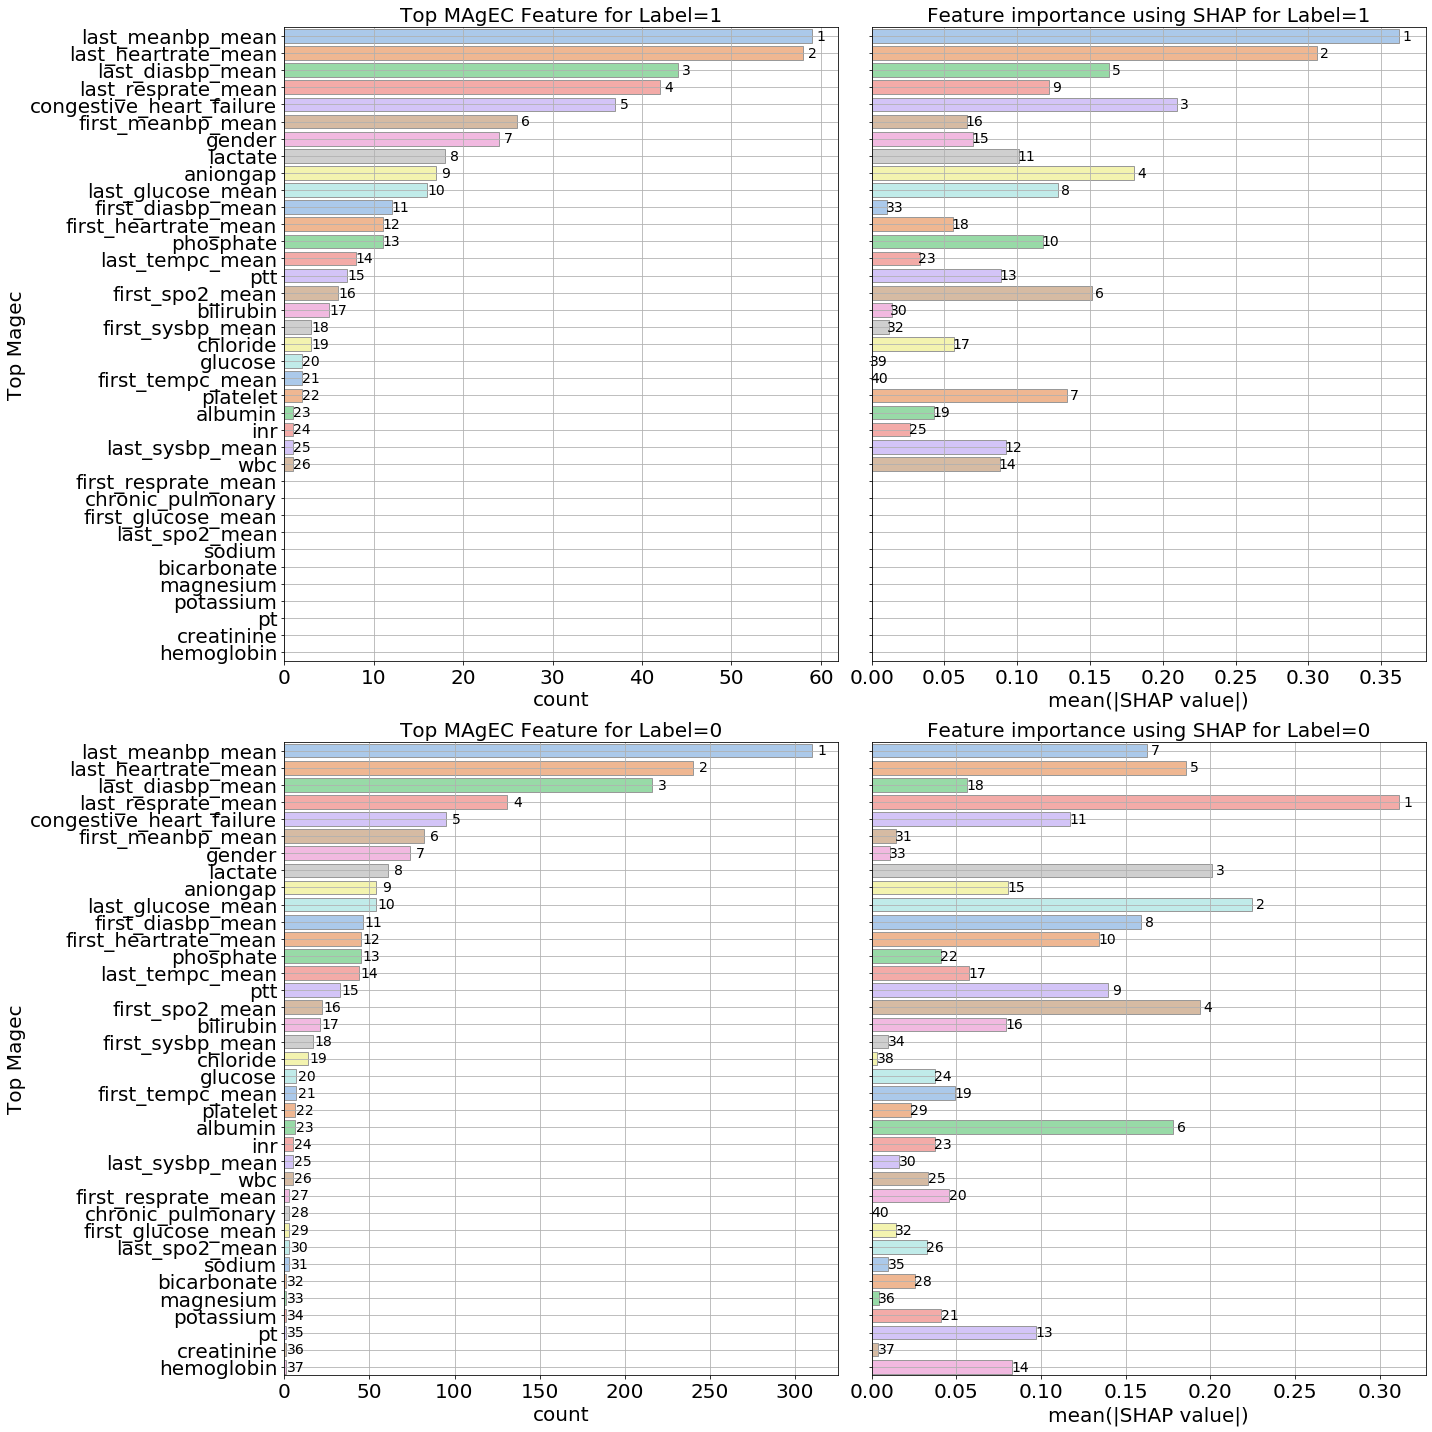

In [230]:
plot_feat_importance2(consensus_heto, shaps, save='magec_shap_comp2.png');

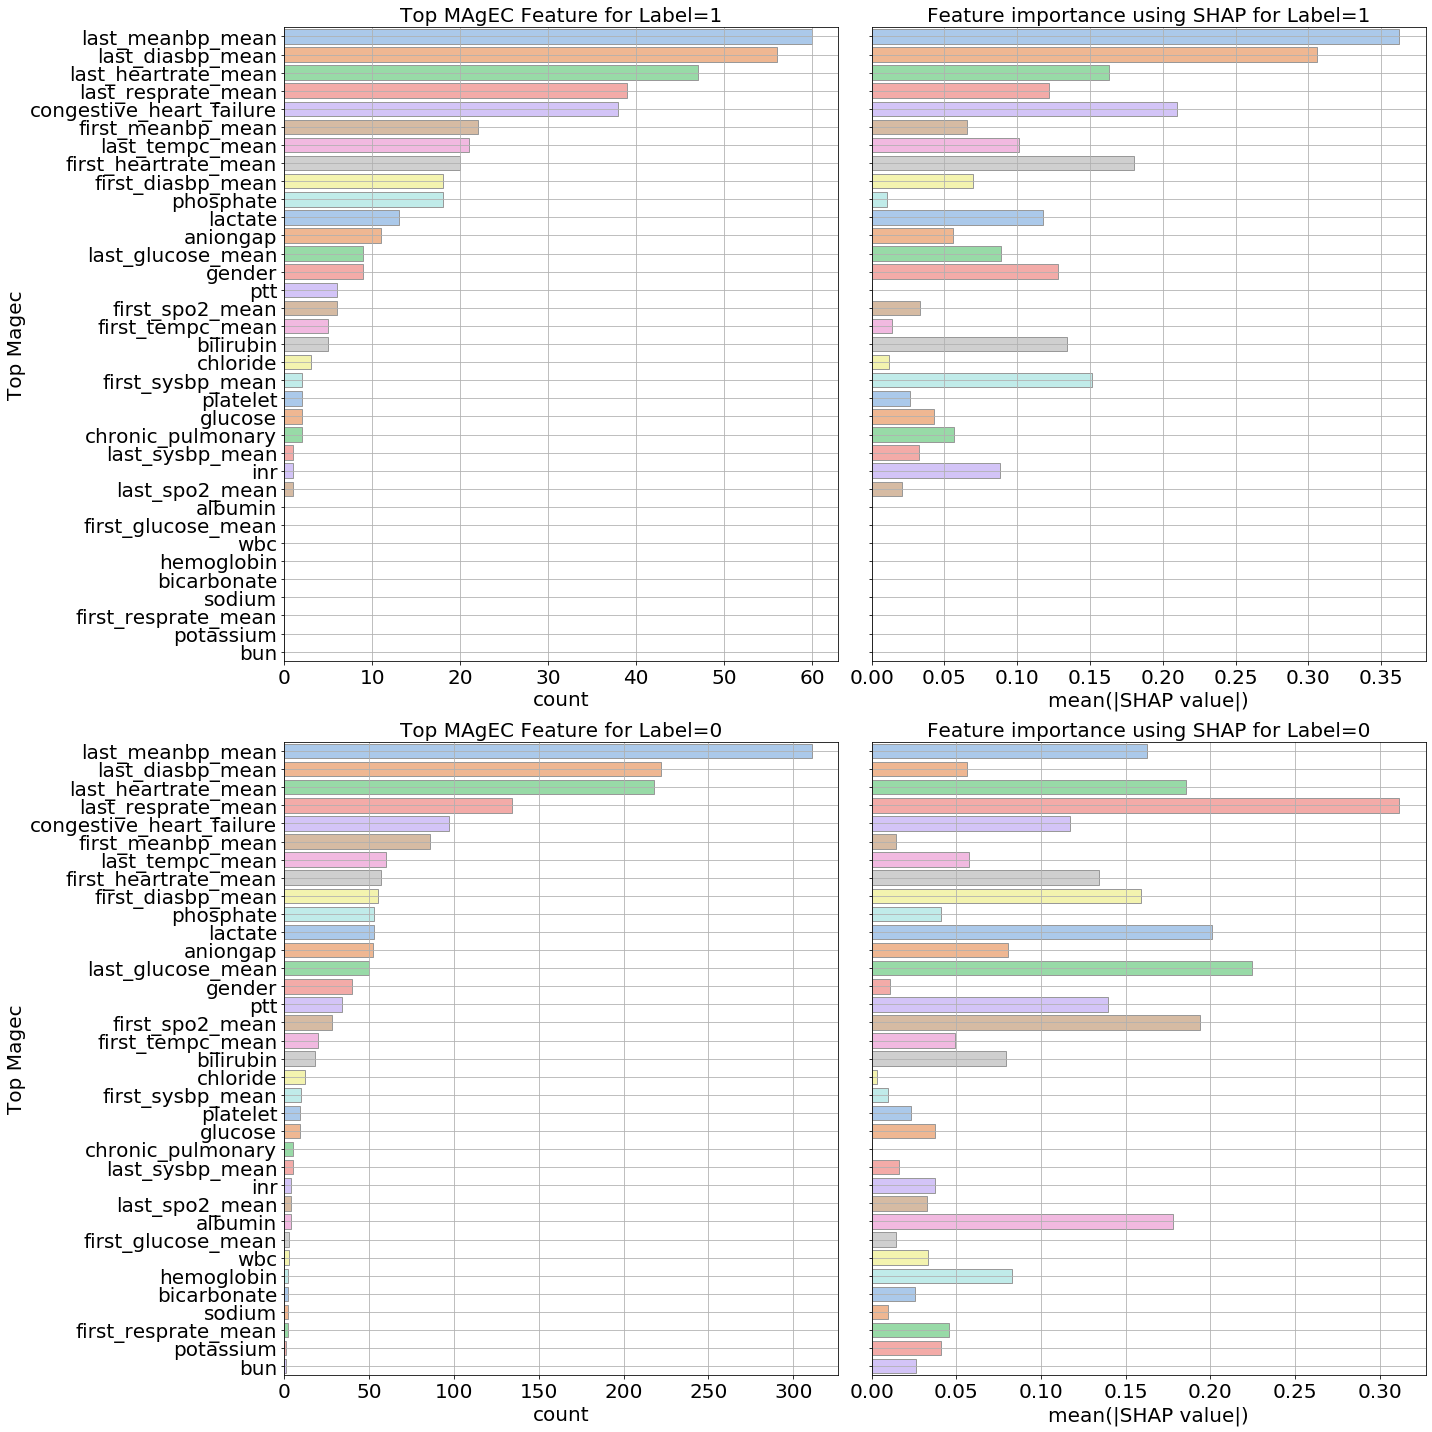

In [37]:
plot_feat_importance(consensus_heto, shaps, save='magec_shap_comp.png')

In [41]:
'creatinine' in consensus_heto.groupby(['winner'])['rbo'].mean().index.tolist()

False

In [42]:
'creatinine' in consensus_homo.groupby(['winner'])['rbo'].mean().index.tolist()

True

In [43]:
'potassium' in consensus_heto.groupby(['winner'])['rbo'].mean().index.tolist()

True

In [44]:
'potassium' in consensus_homo.groupby(['winner'])['rbo'].mean().index.tolist()

False

## Sensitivity and Specificity
- Sensitivity measures the proportion of positives that are correctly identified (e.g., the percentage of sick people who are correctly identified as having some illness).
-  Specificity measures the proportion of negatives that are correctly identified (e.g., the percentage of healthy people who are correctly identified as not having some illness).

In [64]:
# Accuracy: 0.816131
# Precision: 0.533465
# Recall: 0.649880
# F1 score: 0.585946
# ROC AUC: 0.832637
# [[1429  237]
#  [ 146  271]]
tn = 1429
fp = 237
tp = 271
fn = 146
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
print('MLP ', sensitivity, specificity)

# Accuracy: 0.783485
# Precision: 0.472131
# Recall: 0.690647
# F1 score: 0.560857
# ROC AUC: 0.813949
# [[1344  322]
#  [ 129  288]]
tn = 1344
fp = 322
tp = 288
fn = 129
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
print('SVM ', sensitivity, specificity)

# Accuracy: 0.672588
# Precision: 0.339782
# Recall: 0.673861
# F1 score: 0.451768
# ROC AUC: 0.721519
# [[1120  546]
#  [ 136  281]]
tn = 1120
fp = 546
tp = 281
fn = 136
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
print('LR ', sensitivity, specificity)

MLP  0.6498800959232613 0.8577430972388955
SVM  0.6906474820143885 0.8067226890756303
LR  0.6738609112709832 0.6722689075630253


In [50]:
others = list()
models = ('lr', 'svm', 'mlp')
for i,m in enumerate([lr, sv, mlp3]):
    preds = pd.DataFrame(m.predict_proba(xst_valid)[:, 1])
    preds.columns = [models[i] + '_prob_1']
    others.append(preds)

In [51]:
preds = pd.concat(others + [Y_valid.reset_index()], axis=1)

In [52]:
preds['ensemble_prob'] = preds[['lr_prob_1','svm_prob_1','mlp_prob_1']].mean(axis=1)

In [53]:
preds['class_1'] = (preds['ensemble_prob'] >= 0.5).astype(int)

In [54]:
accuracy, precision, recall, f1, auc = mg.model_metrics(preds['ensemble_prob'],
                                                        preds['class_1'],
                                                        preds['label'],
                                                        verbose=True)

Accuracy: 0.826692
Precision: 0.561947
Recall: 0.609113
F1 score: 0.584580
ROC AUC: 0.824505
[[1468  198]
 [ 163  254]]


In [65]:
tn = 1468
fp = 198
tp = 254
fn = 163
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
print('Ensemble ', sensitivity, specificity)

Ensemble  0.6091127098321343 0.8811524609843937


In [67]:
print('TN', np.sum((preds['label']==0) & (preds['class_1'] == preds['label'])))
print('FP', np.sum((preds['label']==0) & (preds['class_1'] != preds['label'])))
print('TP', np.sum((preds['label']==1) & (preds['class_1'] == preds['label'])))
print('FN', np.sum((preds['label']==1) & (preds['class_1'] != preds['label'])))

TN 1468
FP 198
TP 254
FN 163


## How to increase recall and sensitivity w/ xgboost (closer to SOTA)

In [76]:
xg2 = xgboost.XGBClassifier(scale_pos_weight=6.5)
xg2.fit(xst_train, Y_train['label'])
mg.evaluate(xg2, xst_valid, Y_valid['label'], verbose=True);

Accuracy: 0.724436
Precision: 0.403206
Recall: 0.784173
F1 score: 0.532573
ROC AUC: 0.831050
[[1182  484]
 [  90  327]]


In [77]:
tn = 1182
fp = 484
tp = 327
fn = 90
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
print('xgboost ', sensitivity, specificity)

xgboost  0.7841726618705036 0.709483793517407
